## 1、成功导入期货数据，提交robo3t(即Robomongo)中的数据库截图

<img src="360截图1700101791124100.png">

## 2、读取JD88:CTP的数据，绘出JD88:CTP的价格图和jaqs_fxdayu算法图。


In [1]:
from datetime import datetime
import talib as ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from datautils.mongodb import read
from pymongo import MongoClient

In [3]:
client=MongoClient()
JD88=read(client['VnTrader_1Min_Db']['JD88:CTP']).set_index('datetime')

In [4]:
JD88.tail()

,close,date,exchange,high,low,open,openInterest,symbol,time,trading_date,volume,vtSymbol
datetime,,,,,,,,,,,,
2019-03-21 14:55:00,3506.0,20190321,CTP,3508.0,3506.0,3507.0,135070,JD88,14:55:00,2019-03-21,390,JD88:CTP
2019-03-21 14:56:00,3507.0,20190321,CTP,3508.0,3505.0,3506.0,135066,JD88,14:56:00,2019-03-21,446,JD88:CTP
2019-03-21 14:57:00,3507.0,20190321,CTP,3508.0,3505.0,3506.0,134770,JD88,14:57:00,2019-03-21,848,JD88:CTP
2019-03-21 14:58:00,3507.0,20190321,CTP,3508.0,3505.0,3506.0,134134,JD88,14:58:00,2019-03-21,1118,JD88:CTP
2019-03-21 14:59:00,3507.0,20190321,CTP,3508.0,3505.0,3505.0,133466,JD88,14:59:00,2019-03-21,1316,JD88:CTP


In [5]:
def resampleDF(data,freq='H'):
    return data.resample(freq).agg({'open':'first','high':'max','low':'min','close':'last','volume':'sum'})#agg对分组的数据进行相应的聚合运算

In [6]:
dataJD=resampleDF(JD88,freq='15min')

In [7]:
dataJD.tail()

,open,high,low,close,volume
datetime,,,,,
2019-03-21 13:45:00,3504.0,3510.0,3503.0,3507.0,5318
2019-03-21 14:00:00,3507.0,3508.0,3504.0,3508.0,2730
2019-03-21 14:15:00,3508.0,3512.0,3506.0,3507.0,5080
2019-03-21 14:30:00,3507.0,3509.0,3506.0,3507.0,3012
2019-03-21 14:45:00,3507.0,3509.0,3503.0,3507.0,7086


In [8]:
#reset_index
#datetime to int
def dt2int(t):
    return t.year*10**10+t.month*10**8+t.day*10**6+t.hour*10**4+t.minute*10**2+t.second
def modifyDf(data,symbol):
    assert isinstance(data,pd.DataFrame)
    data=data.reset_index()#reset_index是set_index的逆操作
    data['trade_date']=data['datetime'].apply(dt2int)
    data['symbol']=symbol
    return data

In [9]:
dataJd=modifyDf(dataJD,'JD88')

In [10]:
dataJd.head(8)

,datetime,open,high,low,close,volume,trade_date,symbol
0,2015-01-05 09:00:00,4255.0,4296.0,4255.0,4288.0,32610,20150105090000,JD88
1,2015-01-05 09:15:00,4288.0,4290.0,4276.0,4283.0,10196,20150105091500,JD88
2,2015-01-05 09:30:00,4283.0,4288.0,4269.0,4280.0,8832,20150105093000,JD88
3,2015-01-05 09:45:00,4278.0,4282.0,4265.0,4278.0,12246,20150105094500,JD88
4,2015-01-05 10:00:00,4278.0,4281.0,4272.0,4275.0,4164,20150105100000,JD88
5,2015-01-05 10:15:00,NaN,NaN,NaN,NaN,0,20150105101500,JD88
6,2015-01-05 10:30:00,4275.0,4280.0,4273.0,4278.0,2764,20150105103000,JD88
7,2015-01-05 10:45:00,4279.0,4285.0,4277.0,4280.0,3778,20150105104500,JD88


In [11]:
from jaqs_fxdayu.data.hf_dataview import HFDataView
dv=HFDataView()

In [12]:
dv.create_init_dv(dataJd.dropna().set_index(['trade_date', 'symbol']))

Initialize dataview success.


In [13]:
close=dv.get_ts('close',date_type='datetime')
alpha11=dv.add_formula('alpha11',"Ts_Sum(((close-low) - (high-close)) / (high-low) * volume,6)",add_data=True)

In [14]:
alpha191=dv.get_ts('alpha11',date_type='datetime')

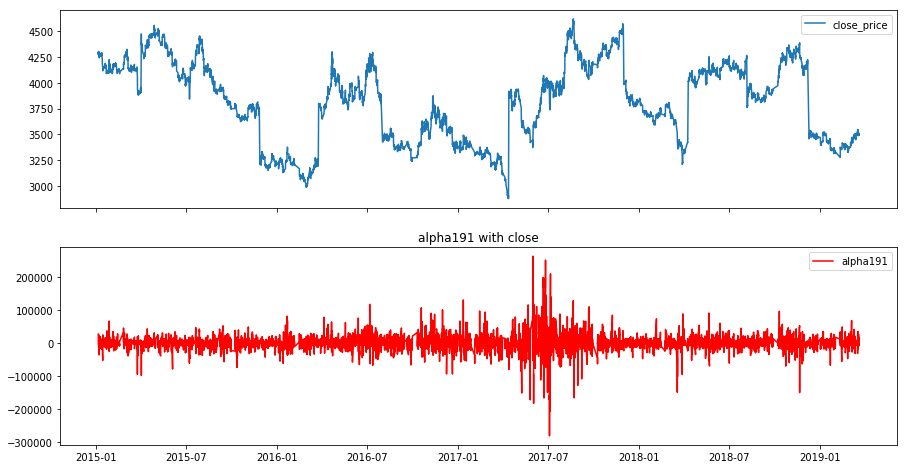

In [15]:
fig,axes = plt.subplots(2,1,sharex=True, figsize=(15,8))
axes[0].plot(close,label='close_price')
axes[0].legend()
axes[1].plot(alpha191,'r',label='alpha191')
plt.legend()
plt.title('alpha191 with close')
plt.show()

In [16]:
#创建KDJ的算法因子
close=dv.get_ts('close',date_type='datetime')
KDJ_D_J=dv.add_formula('KDJ_D_J',"Sma(Sma((close-Ts_Min(low,9))/(Ts_Max(high,9)-Ts_Min(low,9))*100,3,1),3,1)",add_data=True)

In [17]:
KDJ=dv.get_ts('KDJ_D_J',date_type='datetime')

In [18]:
KDJ.tail()

symbol,JD88
trade_date,
2019-03-21 13:45:00,42.438757
2019-03-21 14:00:00,50.306781
2019-03-21 14:15:00,56.547372
2019-03-21 14:30:00,61.371260
2019-03-21 14:45:00,65.029514


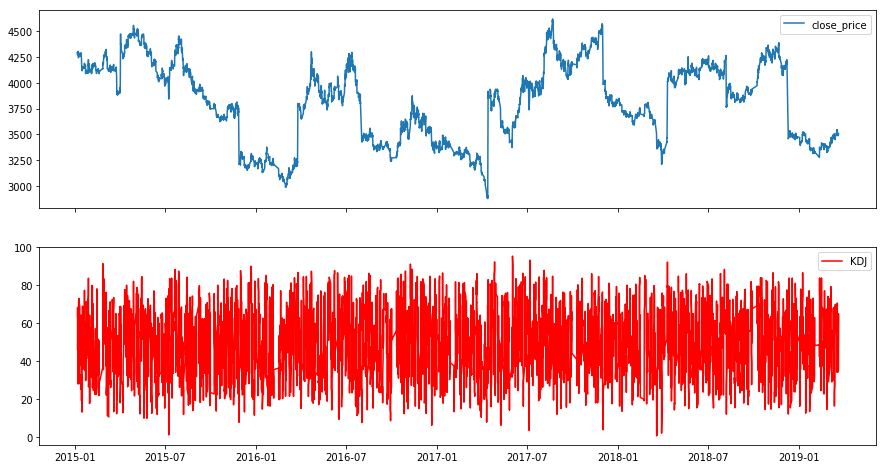

In [19]:
fig,axes = plt.subplots(2,1,sharex=True, figsize=(15,8))
axes[0].plot(close,label='close_price')
axes[0].legend()
axes[1].plot(KDJ,'r',label='KDJ')
plt.legend()
plt.show()

In [20]:
#创建Psy G010004A因子指标
close=dv.get_ts('close',date_type='datetime')
psy_j = dv.add_formula("psy_j", "Ts_Sum(close>Delay(close,1),12)/12", add_data=True)

C:\Users\tansai\Anaconda3.7\lib\site-packages\jaqs-0.6.11-py3.6.egg\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr


In [21]:
psy=dv.get_ts('psy_j',date_type='datetime')

In [22]:
psy.tail()

symbol,JD88
trade_date,
2019-03-21 13:45:00,0.500000
2019-03-21 14:00:00,0.583333
2019-03-21 14:15:00,0.500000
2019-03-21 14:30:00,0.416667
2019-03-21 14:45:00,0.416667


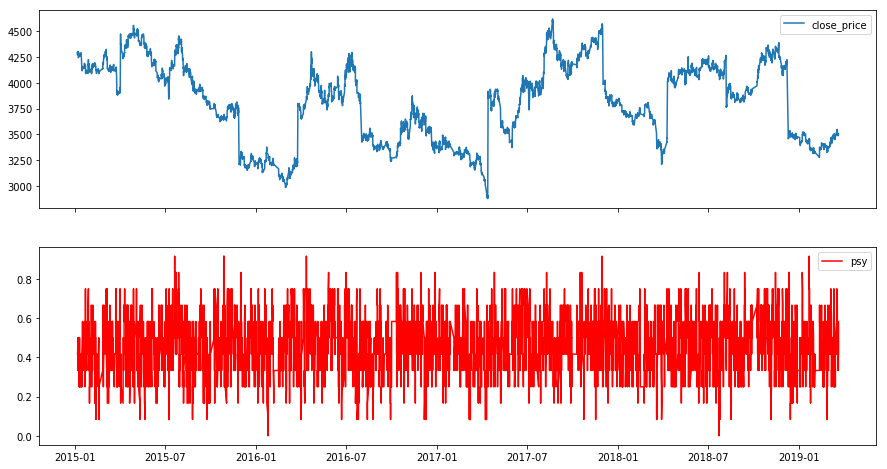

In [23]:
fig,axes = plt.subplots(2,1,sharex=True, figsize=(15,8))
axes[0].plot(close,label='close_price')
axes[0].legend()
axes[1].plot(psy,'r',label='psy')
plt.legend()
plt.show()

## 3、计算volume的均值和标准差，计算周期为20，选择数据库中的任一品种、需要去除停牌时间，绘制相关图片。

In [24]:
client=MongoClient()
B88=read(client['VnTrader_1Min_Db']['B88:CTP'],datetime=(datetime(2018,1,1),datetime(2019,3,21))).set_index('datetime')

In [25]:
dataB=resampleDF(B88,freq='15min')

In [26]:
#reset_index
#datetime to int
def dt2int(t):
    return t.year*10**10+t.month*10**8+t.day*10**6+t.hour*10**4+t.minute*10**2+t.second
def modifyDf(data,symbol):
    assert isinstance(data,pd.DataFrame)
    data=data.reset_index()#reset_index是set_index的逆操作
    data['trade_date']=data['datetime'].apply(dt2int)
    data['symbol']=symbol
    return data

In [27]:
dataB88=modifyDf(dataB,'B88:CTP')

In [28]:
dv=HFDataView()
dv.create_init_dv(dataB88.dropna().set_index(['trade_date', 'symbol']))

Initialize dataview success.


In [29]:
dataB88.tail()

,datetime,open,high,low,close,volume,trade_date,symbol
42485,2019-03-20 22:15:00,2867.0,2869.0,2867.0,2868.0,856,20190320221500,B88:CTP
42486,2019-03-20 22:30:00,2868.0,2872.0,2868.0,2871.0,2260,20190320223000,B88:CTP
42487,2019-03-20 22:45:00,2871.0,2873.0,2871.0,2873.0,1432,20190320224500,B88:CTP
42488,2019-03-20 23:00:00,2873.0,2875.0,2872.0,2873.0,1522,20190320230000,B88:CTP
42489,2019-03-20 23:15:00,2873.0,2877.0,2873.0,2877.0,1746,20190320231500,B88:CTP


In [30]:
dataB88.volume = dataB88.volume.astype('float')
dv.create_init_dv(dataB88.dropna().set_index(['trade_date', 'symbol']))
ema = dv.add_formula('EMA', "Ta('EMA',0,0,0,0,volume,0,20)",add_data=True)
std=dv.add_formula('STDDEV',"Ta('STDDEV',0,0,0,0,volume,0,20,1)",add_data=True)

Initialize dataview success.


C:\Users\tansai\Anaconda3.7\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:45: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  candle_pannel = pd.Panel.from_dict(candle_dict)


In [31]:
ema.tail()

symbol,B88:CTP
trade_date,
20190320221500,3488.121363
20190320223000,3371.157424
20190320224500,3186.475764
20190320230000,3027.954263
20190320231500,2905.863381


In [32]:
DataDf = pd.DataFrame({
                        'volume':dv.get_ts('volume', date_type = 'datetime')['B88:CTP'],
                        'ema': dv.get_ts('EMA', date_type='datetime')['B88:CTP'],
                        'stddev':dv.get_ts('STDDEV', date_type='datetime')['B88:CTP'],}
                      )
DataDf.tail()

,volume,ema,stddev
trade_date,,,
2019-03-20 22:15:00,856.0,3488.121363,4242.213073
2019-03-20 22:30:00,2260.0,3371.157424,4201.246400
2019-03-20 22:45:00,1432.0,3186.475764,4214.238174
2019-03-20 23:00:00,1522.0,3027.954263,4191.637551
2019-03-20 23:15:00,1746.0,2905.863381,4207.393391


In [33]:
data_B88 = DataDf.reset_index()
data_B88['tradeDateStr']=list(map(lambda x:x.strftime(format='%Y-%m-%d %H:%M:%S'),list(data_B88.trade_date)))

In [34]:
def chartRange(df, n=100):
    fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(15,15))
    ax.plot(df.index[-n:], df.volume.iloc[-n:])
    ax1.plot(df.index[-n:], df.ema.iloc[-n:])
    ax1.plot(df.index[-n:], df.stddev.iloc[-n:])
    plt.xticks([df.index[-n:][0],df.index[-n:][int(n/2)],df.index[-n:][-1]],[df.tradeDateStr.iloc[0],df.tradeDateStr.iloc[int(n/2)],df.tradeDateStr.iloc[-1]])
    plt.show()

In [35]:
data_B88.tail()

,trade_date,volume,ema,stddev,tradeDateStr
7265,2019-03-20 22:15:00,856.0,3488.121363,4242.213073,2019-03-20 22:15:00
7266,2019-03-20 22:30:00,2260.0,3371.157424,4201.246400,2019-03-20 22:30:00
7267,2019-03-20 22:45:00,1432.0,3186.475764,4214.238174,2019-03-20 22:45:00
7268,2019-03-20 23:00:00,1522.0,3027.954263,4191.637551,2019-03-20 23:00:00
7269,2019-03-20 23:15:00,1746.0,2905.863381,4207.393391,2019-03-20 23:15:00


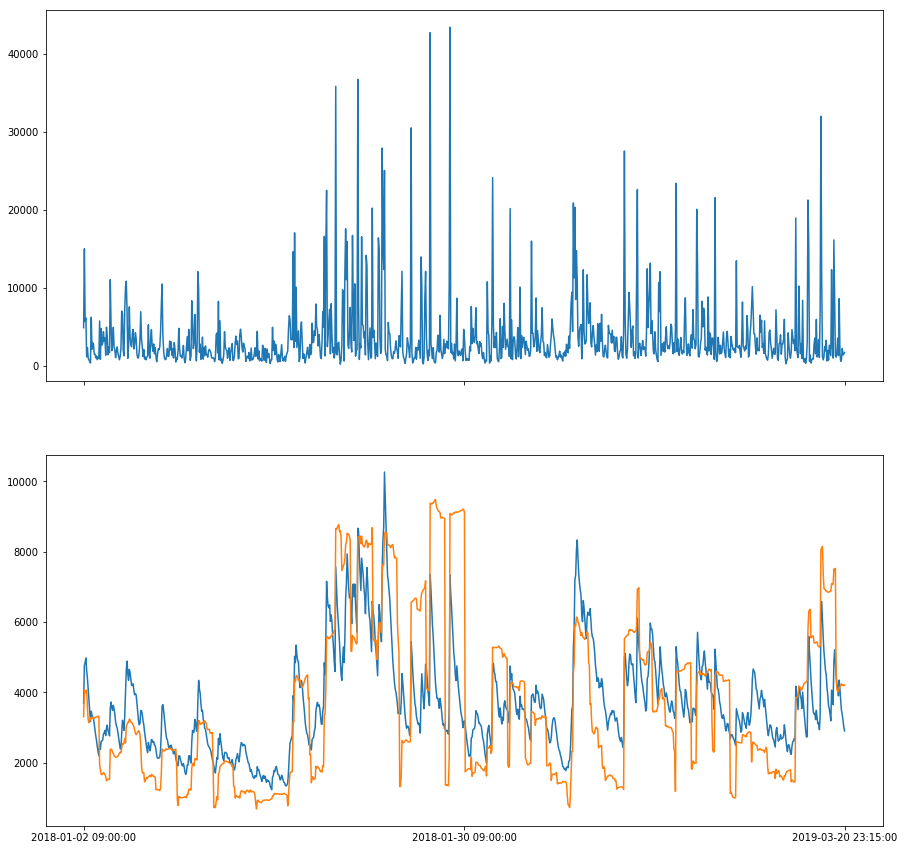

In [36]:
chartRange(data_B88,n=1000)